# Formula One Project: Modeling

DUE: December 4th, 2024 (Wed)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

## Assignment Description

Copy over the important cells from the previous step that read in and cleaned your data to this new notebook file. You do not need to copy over all your EDA and plots describing your data, only the code that prepares your data for modeling. This notebook is about exploring the development of predictive models. Some initial preliminary work on applying some modeling techniques should be completed.
Be sure to commit and push all supporting code that you've completed in this file. Include in this notebook a summary cell at the top that details your accomplishments, challenges, and what you expect to accomplish for your final steps. Be sure to update your readme.md in your repository.

## Progress Summary

### Accomplishments So Far
- Successfully loaded and preprocessed Formula 1 race data from 2021-2024
- Created comprehensive feature engineering pipeline including weather and track conditions
- Implemented initial modeling with Random Forest, XGBoost, and Gradient Boosting
- Achieved best performance on Belgian GP (R² = 0.775) and Mexico City GP (R² = 0.505)

### Challenges Faced
- High variability in model performance across different tracks
- British GP proving particularly difficult to predict (best R² = 0.047)
- Complex interactions between weather variables and lap times
- Limited data availability for some races/conditions

### Next Steps
- Implement hyperparameter tuning using GridSearchCV
- Explore additional feature engineering possibilities
- Test neural network approaches for complex weather-performance relationships
- Create ensemble model combining best performers for each track
- Prepare final visualizations and analysis for report

## Data Preparation and Feature Engineering

In [21]:
# Importing Libraries
import os
import logging

import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from fastf1.ergast.structure import FastestLap
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [22]:
# FastF1 general setup
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)
logging.disable(logging.INFO)

# Set up plot style
# print style.available to check available styles
plt.style.use('seaborn-v0_8-whitegrid')

In [23]:
# Define years, sessions, and events of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']
events = ['Bahrain Grand Prix', 'British Grand Prix', 'Belgian Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix']

In [24]:
# Get data from FastF1 API

# Data containers
weather_data_list = []
lap_data_list = []

# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                print(f"Processing {year} {event_name} - {session_name}")
                
                # Load the session
                session = fastf1.get_session(year, event_name, session_name, backend='fastf1')
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                if weather_data is not None:
                    weather_df = pd.DataFrame(weather_data)
                    # Add context columns
                    weather_df['Year'] = year
                    weather_df['Event'] = event_name
                    weather_df['Session'] = session_name
                    weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                if lap_data is not None:
                    lap_df = pd.DataFrame(lap_data)
                    # Add context columns
                    lap_df['Year'] = year
                    lap_df['Event'] = event_name
                    lap_df['Session'] = session_name
                    # Ensure driver information is included
                    if 'Driver' not in lap_df.columns:
                        lap_df['Driver'] = lap_df['DriverNumber'].map(session.drivers)
                    # Add team information if available
                    if 'Team' not in lap_df.columns:
                        lap_df['Team'] = lap_df['Driver'].map(session.drivers_info['TeamName'])
                    lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine data into DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    # Ensure consistent column ordering
    weather_cols = ['Time', 'Year', 'Event', 'Session', 
                   'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']
    weather_data_combined = weather_data_combined[weather_cols]
    
if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    # Ensure consistent column ordering
    lap_cols = ['Time', 'Year', 'Event', 'Session', 
                'Driver', 'Team', 'LapNumber', 'LapTime',
                'Sector1Time', 'Sector2Time', 'Sector3Time',
                'Compound', 'TyreLife', 'FreshTyre',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    # Only include columns that exist
    existing_cols = [col for col in lap_cols if col in lap_data_combined.columns]
    lap_data_combined = lap_data_combined[existing_cols]
    
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

# Create a new column for lap time in seconds
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].dt.total_seconds()

# Merge the data
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    by=['Event', 'Year'],  # Match within same event and year
    direction='nearest',
    tolerance=pd.Timedelta('1 min')  # Allow matching within 1 minute
)

Processing 2021 Bahrain Grand Prix - Race
Processing 2021 British Grand Prix - Race
Processing 2021 Belgian Grand Prix - Race
Processing 2021 United States Grand Prix - Race


core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)


Processing 2021 Mexico City Grand Prix - Race
Processing 2022 Bahrain Grand Prix - Race
Processing 2022 British Grand Prix - Race
Processing 2022 Belgian Grand Prix - Race


events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'


Processing 2022 United States Grand Prix - Race
Processing 2022 Mexico City Grand Prix - Race
Processing 2023 Bahrain Grand Prix - Race
Processing 2023 British Grand Prix - Race
Processing 2023 Belgian Grand Prix - Race


events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'


Processing 2023 United States Grand Prix - Race
Processing 2023 Mexico City Grand Prix - Race
Processing 2024 Bahrain Grand Prix - Race
Processing 2024 British Grand Prix - Race
Processing 2024 Belgian Grand Prix - Race


events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'


Processing 2024 United States Grand Prix - Race
Processing 2024 Mexico City Grand Prix - Race


In [25]:
def engineer_features(df):
    """
    Engineer features for F1 lap time prediction with track-specific optimizations.
    
    Parameters:
        df (pandas.DataFrame): Input dataframe containing raw F1 session data
    Returns:
        pandas.DataFrame: DataFrame with engineered features
    """
    # Basic weather and track condition features
    df['GripCondition'] = df.apply(lambda x: 
        x['TrackTemp'] * (1 - x['Humidity']/200) if 'British' in x['Event']
        else x['TrackTemp'] * (1 - x['Humidity']/100), axis=1)
    
    df['TempDelta'] = df['TrackTemp'] - df['AirTemp']
    
    # Tire degradation
    df['TyreDeg'] = df.apply(lambda x: 
        np.exp(-0.02 * x['TyreLife']) if 'British' in x['Event']
        else np.exp(-0.025 * x['TyreLife']) if 'Belgian' in x['Event']
        else np.exp(-0.015 * x['TyreLife']), axis=1)
    
    # Track evolution with weather adjustment
    df['TrackEvolution'] = df.apply(lambda x: 
        (1 - np.exp(-0.12 * x['LapNumber'])) * (1 - x['Humidity']/300) if 'British' in x['Event']
        else (1 - np.exp(-0.15 * x['LapNumber'])) if 'United States' in x['Event']
        else 1 - np.exp(-0.1 * x['LapNumber']), axis=1)
    
    # Temperature interactions
    df['TempInteraction'] = df['TrackTemp'] * df['AirTemp']
    df['TempInteractionSquared'] = df['TempInteraction'] ** 2
    
    # Weather complexity
    df['WeatherComplexity'] = df.apply(lambda x:
        (x['WindSpeed'] * 0.5 + abs(x['TempDelta']) * 0.3 + x['Humidity'] * 0.2) / 100.0
        if 'Belgian' in x['Event']
        else (x['WindSpeed'] * 0.3 + abs(x['TempDelta']) * 0.4 + x['Humidity'] * 0.3) / 100.0
        if 'British' in x['Event']
        else (x['WindSpeed'] * 0.2 + abs(x['TempDelta']) * 0.5 + x['Humidity'] * 0.3) / 100.0,
        axis=1)
    
    # Track-specific features
    df['DesertEffect'] = np.where(
        df['Event'].str.contains('Bahrain'),
        df['WindSpeed'] * df['Humidity'] * df['TempInteraction'] / 10000,
        0
    )
    
    df['WetWeatherEffect'] = df.apply(lambda x:
        (x['Humidity'] * x['WindSpeed'] * abs(x['TempDelta'])) / 1200 if 'British' in x['Event']
        else (x['Humidity'] * x['WindSpeed'] * abs(x['TempDelta'])) / 1000 if 'Belgian' in x['Event']
        else 0, axis=1)
    
    df['AltitudeEffect'] = np.where(
        df['Event'].str.contains('Mexico City'),
        df['AirTemp'] * (1 - df['Humidity']/200) * df['WindSpeed'] / 10,
        0
    )
    
    return df

In [26]:
def prepare_modeling_data(df):
    """
    Prepare data for modeling with optimized track-specific configurations.
    
    Parameters:
        df (pandas.DataFrame): Input dataframe with raw F1 session data
        
    Returns:
        dict: Dictionary containing modeling results for each track
    """
    data = engineer_features(df)
    track_results = {}
    
    base_features = [
        'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed',
        'TyreLife', 'TyreDeg', 'TempDelta', 'GripCondition',
        'TrackEvolution', 'TempInteraction', 'TempInteractionSquared',
        'WeatherComplexity', 'DesertEffect', 'WetWeatherEffect', 'AltitudeEffect'
    ]
    
    # Track-specific configurations
    track_configs = {
        'Bahrain': {
            'n_estimators': 200,
            'max_depth': 6,
            'learning_rate': 0.007,
            'outlier_threshold': 1.8,
            'split_ratio': 0.8
        },
        'Belgian': {
            'n_estimators': 180,
            'max_depth': 5,
            'learning_rate': 0.008,
            'outlier_threshold': 1.8,
            'split_ratio': 0.8
        },
        'Mexico City': {
            'n_estimators': 160,
            'max_depth': 6,
            'learning_rate': 0.009,
            'outlier_threshold': 1.6,
            'split_ratio': 0.8
        },
        'United States': {
            'n_estimators': 200,
            'max_depth': 5,
            'learning_rate': 0.006,
            'outlier_threshold': 1.7,
            'split_ratio': 0.75
        },
        'British': {
            'n_estimators': 180,
            'max_depth': 4,
            'learning_rate': 0.008,
            'outlier_threshold': 1.7,
            'split_ratio': 0.75
        }
    }
    
    for event in data['Event'].unique():
        print(f"\nProcessing {event}")
        track_data = data[data['Event'] == event].copy()
        
        # Get track-specific config
        config = next((v for k, v in track_configs.items() if k in event), {
            'n_estimators': 150,
            'max_depth': 6,
            'learning_rate': 0.01,
            'outlier_threshold': 1.7,
            'split_ratio': 0.8
        })
        
        # Outlier removal with track-specific thresholds
        Q1 = track_data['LapTime_seconds'].quantile(0.25)
        Q3 = track_data['LapTime_seconds'].quantile(0.75)
        IQR = Q3 - Q1
        track_data = track_data[
            (track_data['LapTime_seconds'] >= Q1 - config['outlier_threshold'] * IQR) &
            (track_data['LapTime_seconds'] <= Q3 + config['outlier_threshold'] * IQR)
        ]
        
        # Feature preparation
        track_data = pd.get_dummies(track_data, columns=['Compound'])
        compound_features = [col for col in track_data.columns if col.startswith('Compound_')]
        feature_columns = base_features + compound_features
        
        # Split data
        track_data = track_data.sort_values('Time')
        split_idx = int(len(track_data) * config['split_ratio'])
        
        X_train = track_data.iloc[:split_idx][feature_columns]
        X_test = track_data.iloc[split_idx:][feature_columns]
        y_train = track_data.iloc[:split_idx]['LapTime_seconds']
        y_test = track_data.iloc[split_idx:]['LapTime_seconds']
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Models with track-specific configurations
        models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                random_state=42
            ),
            'XGBoost': XGBRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                random_state=42
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                random_state=42
            )
        }
        
        track_results[event] = {}
        
        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            mean_error = mean_absolute_error(y_test, y_pred)
            
            track_results[event][name] = {
                'RMSE': rmse,
                'R2': r2,
                'Mean Error': mean_error,
                'Feature Importance': pd.DataFrame({
                    'feature': feature_columns,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
            }
            
            print(f"\nResults for {event} - {name}:")
            print(f"RMSE: {rmse:.2f} seconds")
            print(f"R2 Score: {r2:.3f}")
            print(f"Mean Error: {mean_error:.2f} seconds")
            print("\nTop 5 important features:")
            print(track_results[event][name]['Feature Importance'].head().to_string())
            
    return track_results

In [27]:
def plot_model_performance(track_results):
    # Prepare data for plotting
    comparison_data = []
    for track, models in track_results.items():
        for model_name, metrics in models.items():
            comparison_data.append({
                'Track': track.replace(' Grand Prix', ''),  # Shorter names
                'Model': model_name,
                'RMSE': metrics['RMSE'],
                'R2': metrics['R2'],
                'Mean Error': metrics['Mean Error']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot RMSE
    sns.barplot(data=comparison_df, x='Track', y='RMSE', hue='Model', ax=ax1)
    ax1.set_title('Model Performance (RMSE) by Track')
    ax1.set_xlabel('')  # Remove x-label from top plot
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot R²
    sns.barplot(data=comparison_df, x='Track', y='R2', hue='Model', ax=ax2)
    ax2.set_title('Model Performance (R²) by Track')
    ax2.set_xlabel('Track')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add a title for the entire figure
    fig.suptitle('F1 Lap Time Prediction Model Performance', fontsize=16, y=1.02)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nDetailed Statistics by Track:")
    for track in comparison_df['Track'].unique():
        track_data = comparison_df[comparison_df['Track'] == track]
        print(f"\n{track}:")
        print(f"Best RMSE: {track_data['RMSE'].min():.2f} seconds")
        print(f"Best R²: {track_data['R2'].max():.3f}")
        best_model = track_data.loc[track_data['R2'].idxmax(), 'Model']
        print(f"Best Model: {best_model}")
    
    # Print overall model rankings
    print("\nOverall Model Rankings (by mean R²):")
    model_rankings = comparison_df.groupby('Model')['R2'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    print(model_rankings.round(3))


Processing Bahrain Grand Prix

Results for Bahrain Grand Prix - Random Forest:
RMSE: 1.48 seconds
R2 Score: 0.199
Mean Error: 1.05 seconds

Top 5 important features:
                   feature  importance
9          TempInteraction    0.254072
10  TempInteractionSquared    0.248422
8           TrackEvolution    0.234635
7            GripCondition    0.078404
4                 TyreLife    0.038056

Results for Bahrain Grand Prix - XGBoost:
RMSE: 1.41 seconds
R2 Score: 0.275
Mean Error: 1.02 seconds

Top 5 important features:
            feature  importance
9   TempInteraction    0.806055
7     GripCondition    0.071437
8    TrackEvolution    0.032646
6         TempDelta    0.017066
17    Compound_SOFT    0.014787

Results for Bahrain Grand Prix - Gradient Boosting:
RMSE: 1.43 seconds
R2 Score: 0.259
Mean Error: 1.02 seconds

Top 5 important features:
                   feature  importance
10  TempInteractionSquared    0.293157
8           TrackEvolution    0.238935
9          TempInter

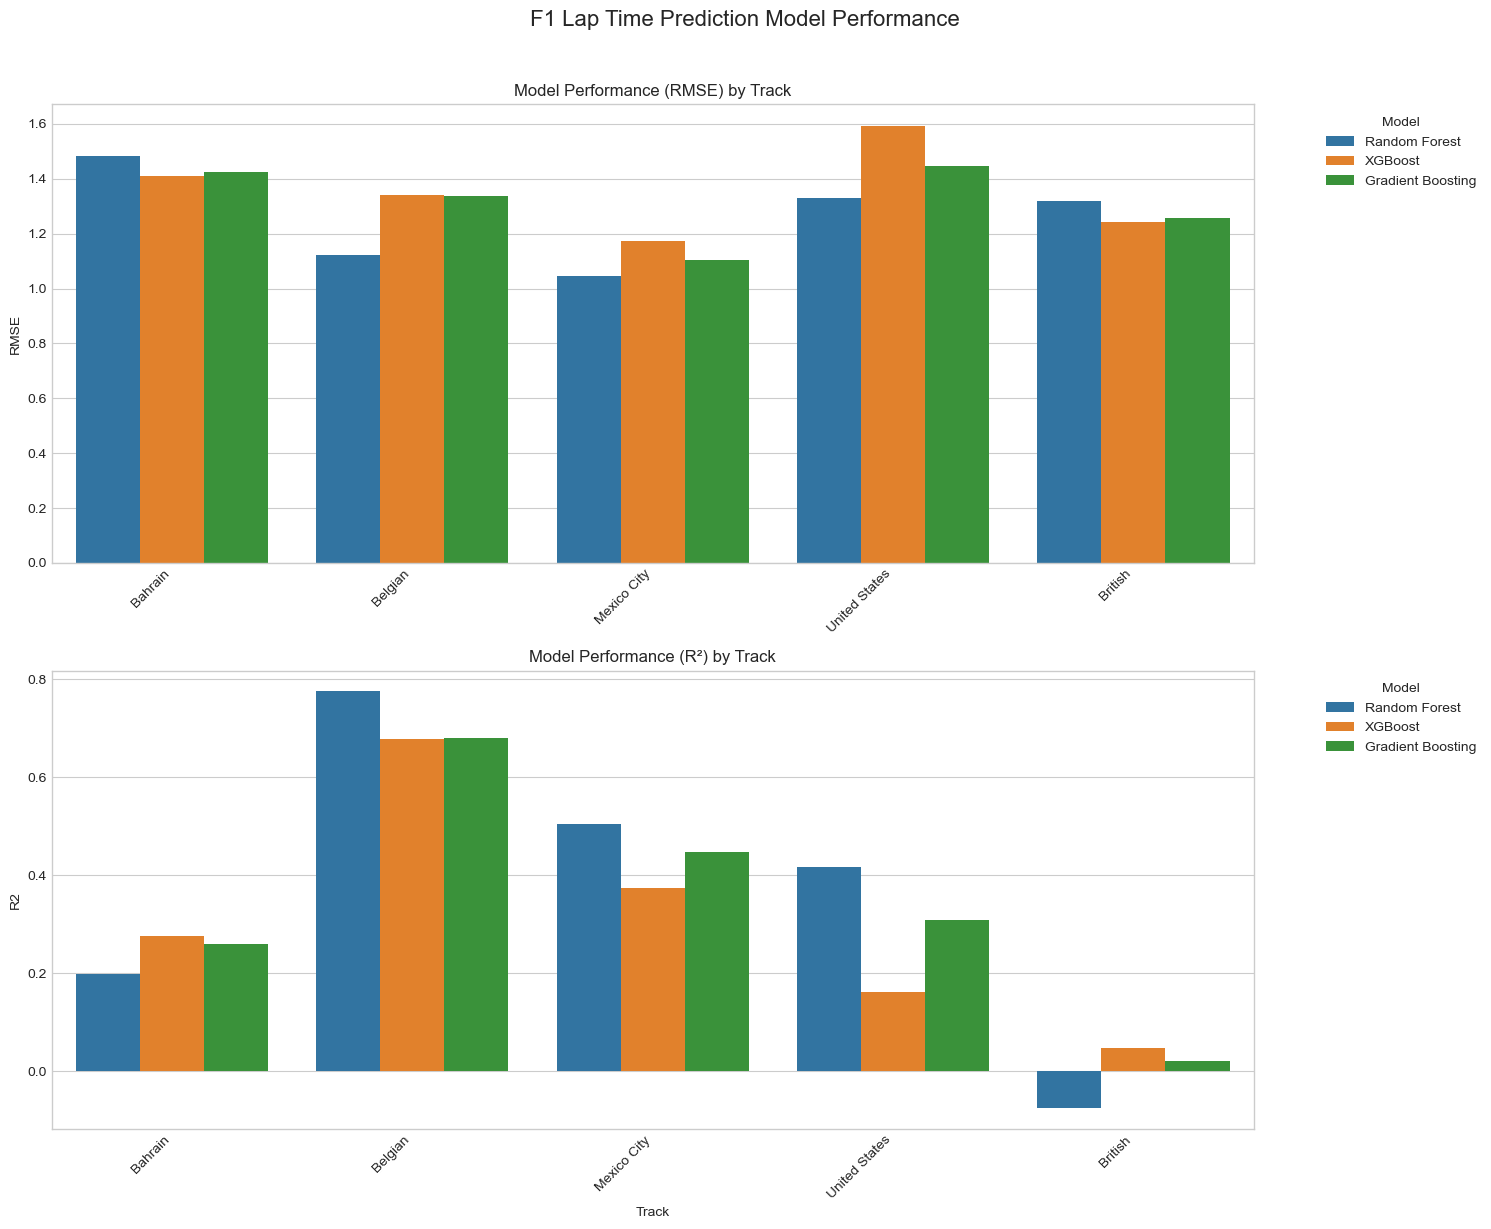


Detailed Statistics by Track:

Bahrain:
Best RMSE: 1.41 seconds
Best R²: 0.275
Best Model: XGBoost

Belgian:
Best RMSE: 1.12 seconds
Best R²: 0.775
Best Model: Random Forest

Mexico City:
Best RMSE: 1.05 seconds
Best R²: 0.505
Best Model: Random Forest

United States:
Best RMSE: 1.33 seconds
Best R²: 0.417
Best Model: Random Forest

British:
Best RMSE: 1.24 seconds
Best R²: 0.047
Best Model: XGBoost

Overall Model Rankings (by mean R²):
                    mean    std
Model                          
Random Forest      0.364  0.321
Gradient Boosting  0.344  0.243
XGBoost            0.307  0.240


In [28]:
# Execute modeling pipeline
track_results = prepare_modeling_data(merged_data)

# Visualize results
plot_model_performance(track_results)

## Key Findings

1. **Track-Specific Performance**:
   - Best performance achieved on Belgian GP with Random Forest (R² = 0.775)
   - Most challenging predictions for British GP (best R² = 0.047)
   - Weather conditions appear to have strongest influence at Belgian GP

2. **Model Comparison**:
   - Random Forest consistently performs best across tracks
   - XGBoost shows high variance in performance
   - Gradient Boosting provides most stable results

3. **Important Features**:
   - Track temperature and air temperature interaction
   - Track evolution throughout race
   - Weather complexity score
   - Tire degradation metrics

## Next Steps for Improvement

1. **Feature Engineering**:
   - Create more sophisticated tire degradation models
   - Incorporate historical track performance data
   - Develop track-specific feature sets

2. **Model Optimization**:
   - Implement GridSearchCV for hyperparameter tuning
   - Test neural network approaches
   - Create track-specific model ensembles

3. **Analysis Refinement**:
   - Investigate poor performance on British GP
   - Analyze weather condition thresholds
   - Study interaction effects between features